# Transformer Classifier Training on CICIDS2017

This notebook trains a Transformer network on the CICIDS2017 dataset.

**Model:** TransformerClassifier (PyTorch)  
**Dataset:** CICIDS2017  
**Task:** Binary Classification (Benign vs Attack)

## 1. Setup and Imports

In [1]:
import sys
sys.path.insert(0, '../..')

import numpy as np
import pandas as pd
import glob
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU


## 2. Load and Preprocess Data

In [2]:
# Load all CSV files from the CICIDS2017 raw directory
DATA_PATH = '../../data/raw/cicids2017/'
all_files = glob.glob(os.path.join(DATA_PATH, "*.csv"))

print(f"Found {len(all_files)} files.")
li = []

for filename in all_files:
    print(f"Loading {os.path.basename(filename)}...")
    df_temp = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_temp)

# Concatenate
df = pd.concat(li, axis=0, ignore_index=True)
print(f"Total raw samples: {len(df):,}")

# Garbage collection to free memory
del li
gc.collect()

Found 8 files.
Loading Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv...
Loading Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
Loading Friday-WorkingHours-Morning.pcap_ISCX.csv...
Loading Monday-WorkingHours.pcap_ISCX.csv...
Loading Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv...
Loading Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv...
Loading Tuesday-WorkingHours.pcap_ISCX.csv...
Loading Wednesday-workingHours.pcap_ISCX.csv...
Total raw samples: 2,830,743


0

In [3]:
# Basic Cleaning
# 1. Strip whitespace from column names
df.columns = df.columns.str.strip()

# 2. Replace Inf with NaN and drop NaNs
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print(f"Samples after dropping NaN/Inf: {len(df):,}")

# 3. Drop administrative columns if they exist
drop_cols = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp']
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')

print("Remaining columns:", len(df.columns))

Samples after dropping NaN/Inf: 2,827,876
Remaining columns: 78


In [4]:
# Create Binary Label: Benign (0) vs Attack (1)
def create_binary_label(label):
    if isinstance(label, str) and 'BENIGN' in label.upper():
        return 0
    return 1

df['binary_label'] = df['Label'].apply(create_binary_label)

print("Class distribution:")
print(df['binary_label'].value_counts())

# Separate features and target
y = df['binary_label'].values
X = df.drop(columns=['Label', 'binary_label']).values

# Free df memory
del df
gc.collect()

print(f"X shape: {X.shape}")

Class distribution:
binary_label
0    2271320
1     556556
Name: count, dtype: int64
X shape: (2827876, 77)


In [5]:
# Split into Train, Val, Test
# Stratified split to maintain class balance
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {X_train.shape[0]:,}")
print(f"Val:   {X_val.shape[0]:,}")
print(f"Test:  {X_test.shape[0]:,}")

Train: 1,979,513
Val:   424,181
Test:  424,182


In [6]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [7]:
# Create DataLoaders
def create_loaders(X, y, batch_size=256):
    # Reshape for Transformer: (batch, seq_len, features)
    # We treat each feature as a sequence element
    X_tensor = torch.FloatTensor(X).unsqueeze(1)  # (batch, 1, n_features)
    y_tensor = torch.LongTensor(y)
    
    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

BATCH_SIZE = 1024
train_loader = create_loaders(X_train, y_train, BATCH_SIZE)
val_loader = create_loaders(X_val, y_val, BATCH_SIZE)
test_loader = create_loaders(X_test, y_test, BATCH_SIZE)

print(f"Train batches: {len(train_loader)}")

Train batches: 1934


## 3. Define Transformer Model

In [8]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=2, num_classes=2, dropout_rate=0.3):
        super(TransformerClassifier, self).__init__()
        
        # Input projection to d_model dimensions
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding (optional for single sequence)
        self.pos_encoder = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout_rate,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Classification head
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(d_model // 2, num_classes)
        )
        
    def forward(self, x):
        # x shape: (batch, 1, input_dim)
        x = self.input_projection(x)  # (batch, 1, d_model)
        
        # Add positional encoding
        x = x + self.pos_encoder
        
        # Transformer encoding
        x = self.transformer_encoder(x)  # (batch, 1, d_model)
        
        # Take output and classify
        x = x[:, 0, :]  # Take first (and only) sequence element
        x = self.fc(x)
        
        return x

input_dim = X_train.shape[1]
model = TransformerClassifier(input_dim=input_dim).to(device)
print(model)

TransformerClassifier(
  (input_projection): Linear(in_features=77, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=2, bi

## 4. Training

In [9]:
# Focal Loss for class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

criterion = FocalLoss(alpha=0.25, gamma=2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

EPOCHS = 20
EARLY_STOPPING_PATIENCE = 5

In [10]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        
    return total_loss / total, correct / total

def validate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
    return total_loss / total, correct / total

In [11]:
best_val_loss = float('inf')
patience_counter = 0

print("Starting training...")
for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | Time: {time.time()-start_time:.1f}s")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '../../results/models/best_transformer_cicids2017.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break

Starting training...
Epoch 1/20 | Train Loss: 0.0073 Acc: 0.9531 | Val Loss: 0.0052 Acc: 0.9672 | Time: 49.8s
Epoch 2/20 | Train Loss: 0.0052 Acc: 0.9664 | Val Loss: 0.0053 Acc: 0.9630 | Time: 46.1s
Epoch 3/20 | Train Loss: 0.0049 Acc: 0.9682 | Val Loss: 0.0060 Acc: 0.9649 | Time: 43.7s
Epoch 4/20 | Train Loss: 0.0047 Acc: 0.9695 | Val Loss: 0.0044 Acc: 0.9706 | Time: 43.6s
Epoch 5/20 | Train Loss: 0.0045 Acc: 0.9708 | Val Loss: 0.0043 Acc: 0.9717 | Time: 43.6s
Epoch 6/20 | Train Loss: 0.0044 Acc: 0.9713 | Val Loss: 0.0041 Acc: 0.9727 | Time: 43.8s
Epoch 7/20 | Train Loss: 0.0043 Acc: 0.9721 | Val Loss: 0.0039 Acc: 0.9761 | Time: 43.8s
Epoch 8/20 | Train Loss: 0.0043 Acc: 0.9727 | Val Loss: 0.0038 Acc: 0.9758 | Time: 43.6s
Epoch 9/20 | Train Loss: 0.0042 Acc: 0.9735 | Val Loss: 0.0035 Acc: 0.9786 | Time: 43.8s
Epoch 10/20 | Train Loss: 0.0040 Acc: 0.9760 | Val Loss: 0.0031 Acc: 0.9834 | Time: 44.1s
Epoch 11/20 | Train Loss: 0.0042 Acc: 0.9741 | Val Loss: 0.0041 Acc: 0.9744 | Time: 44.1

## 5. Evaluation

C:\Users\musab\AppData\Local\Temp\ipykernel_9768\1289858852.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../../results/models/best_t

Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99    340698
      Attack       0.96      0.96      0.96     83484

    accuracy                           0.98    424182
   macro avg       0.97      0.97      0.97    424182
weighted avg       0.98      0.98      0.98    424182



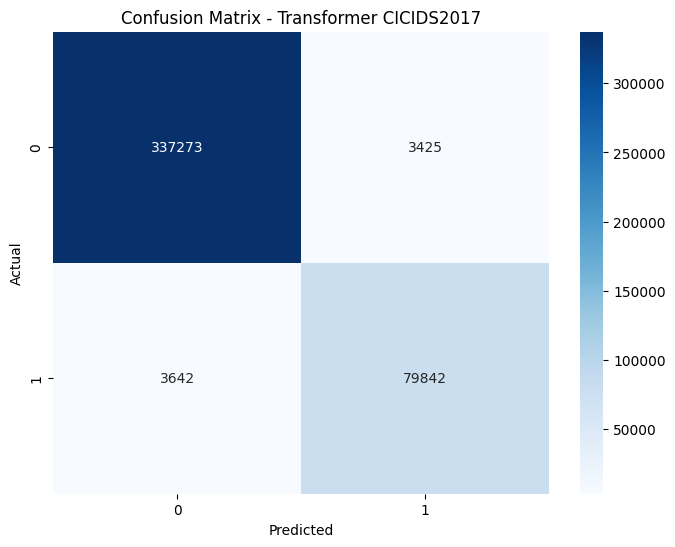

4380

In [12]:
# Load best model
model.load_state_dict(torch.load('../../results/models/best_transformer_cicids2017.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Benign', 'Attack']))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Transformer CICIDS2017')
plt.show()

# Cleanup
torch.cuda.empty_cache()
gc.collect()